## Importing Necessary Libraries 

In [1]:
# pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
df=pd.read_csv("./Fraud.csv")

## Exploratory Data Analysis 

In [4]:
display(df.shape)
display(df.head())

(6362620, 11)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

There are no NaN values, or spelling mistakes the data is rather clean.

In [8]:
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)

Dropping uneccesary columns

## Preprocessing Data

Converting categorical variable to numerical

In [9]:
encoder = LabelEncoder()
df['type'] = encoder.fit_transform(df['type'])

In [10]:
attributes = df[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
target = df[['isFraud']]

Since this is an imbalanced dataset, we're using random over sampling to make the model fit better

In [11]:
randomsampler = RandomUnderSampler(random_state=42)
x, y = randomsampler.fit_resample(attributes, target)

Train test split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=24)

Standardising dataset

In [13]:
x_train_scale = x_train[['amount', 'oldbalanceOrg', 'newbalanceOrig']]
x_test_scale = x_test[['amount', 'oldbalanceOrg', 'newbalanceOrig']]
scaler = StandardScaler().fit(x_train_scale.values)
x_train_scale = scaler.transform(x_train_scale.values)
x_test_scale = scaler.transform(x_test_scale.values)
x_train[['amount', 'oldbalanceOrg', 'newbalanceOrig']], x_test[['amount', 'oldbalanceOrg', 'newbalanceOrig']] = x_train_scale, x_test_scale

## Fitting Model 

Accuracy: 0.9900
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1686
           1       0.98      1.00      0.99      1600

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Confusion Matrix:
[[1660   26]
 [   7 1593]]


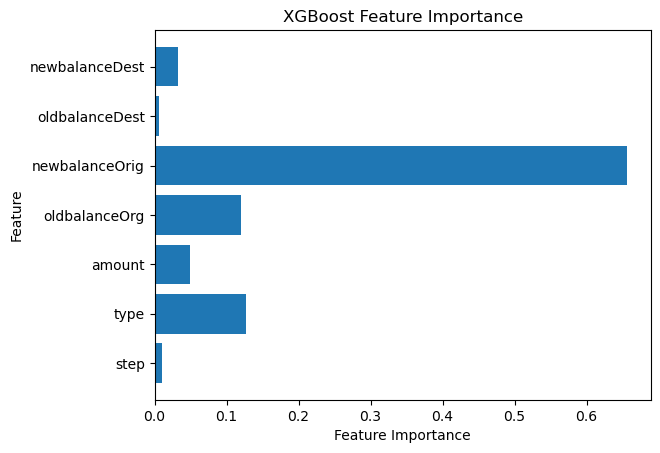

In [14]:
xgb_classifier = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Training the model
xgb_classifier.fit(x_train, y_train)

# Making predictions on the test set
y_pred = xgb_classifier.predict(x_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance (optional)
importance = xgb_classifier.feature_importances_
plt.barh(x_train.columns, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()